# Predicting Profile Features Based on Dialogue
####  Language & Speech & Dialogue Processing Project
##### Sam Titarsolej, Ying Liem, Selina Khan


In [1]:
# # Colab specific drive mounting
# import os
# from google.colab import drive
# drive.mount("/content/drive")
# os.chdir("/content/drive/MyDrive/LSDP/Code")

In [2]:
# !pip install fasttext
# !pip install transformers

# import nltk
# nltk.download('stopwords')

In [3]:
# General imports
import re
import nltk
import json
import time
import requests
import data_utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from bs4 import BeautifulSoup
from collections import Counter, defaultdict

# Imports for the age & gender model
import torch
import transformers as ppb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Imports for the personalities model
import personalities.configuration as config
from personalities.training import train_persona

## Introduction

Dialogue is rich in information and essential for human conversation. In a dialogue, one can convey pieces of info they want their conversation partner to know. For example, plans for tomorrow, newest updates about their lives, etc. However, dialogue can also be used to retrieve underlying information about the conversers. Research suggests that characteristics such as gender[[1]](https://journals.sagepub.com/doi/10.1177/0023830914549084), age[[2]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3783449/) and personality[[2]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3783449/) can influence one’s language usage. Moreover, there's a trend in how such profile features influence language use across feature categories. The aim for this project is to use existing models to propose a method to extract various character traits from dialogue, rather than developing a perfectly functioning model.

Our research question is hereby proposed as follows: “to what extent can dialogue be used to form a profile of a person?”. We aim to answer this question using personas from movies and TV shows, since a lot of data is available in the form of dialogues and profile features. Moreover, this research will focus on the profile features gender, age and personality, resulting in the following subquestions:

1.   “To what extent can dialogue be used to predict the gender of a TV show or movie character?”
2.   “To what extent can dialogue be used to predict the age of a TV show or movie character?”
3. “To what extent can dialogue be used to predict the personality of a TV show or movie character?”

To illustrate the research questions, in the TV-show 'Brooklyn 99', the main character Jake Peralta is an adult male with a quirky personality. By merely analysing the transcript of the show, one could guess Jake's profile features. Take his usage of the word 'bro', which is more commonly used by men. Moreover, he uses words that would normally not be included in a child's vocabulary and doesn't use old-fashioned words that could be seen in the vocabulary of elderly. Based on such observations, one could make an estimation that Jake is an adult. Lastly, a lot of jokes can be found in Jake's dialogue, which could show that he has a quirky personality. \\
However, trends between profile features and dialogue aren't concrete and certain. There are females that also use 'bro' to call their male friend. Also, some children have a much broader vocabulary, whereas not all elderly use old-fashioned words and might even know and use some internet slang. And of course, personalities don't have black and white definitions; you could describe someone as quirky, but that doesn't necessarily mean he/she makes a lot of jokes. Nevertheless, there could be some general trends in language use across profile features that would work for most people. 
Therefore, we will investigate to what extent dialogue can be used to predict gender, age and personality of a TV show or movie character. <br><br>



### Related Literature

Quite some research has already been done in the attempt to extract specific features from dialogue. There are many published papers and articles proposing methods to determine a person’s gender based on spoken dialogues. This includes both audio-based approaches[[3]](http://www.cs.columbia.edu/~sarahita/papers/speech_prosody16.pdf)[[4]](https://ieeexplore.ieee.org/document/7342709)[[5]](https://iranjournals.nlai.ir/bitstream/handle/123456789/621435/50D7B725BB44A32A9317C554F68ADC2D.pdf?sequence=-1) and textual approaches[[6]](https://www.researchgate.net/publication/306093567_Gender-Distinguishing_Features_in_Film_Dialogue)[[7]](https://www.researchgate.net/publication/332017320_Gender_Classification_Using_Sentiment_Analysis_and_Deep_Learning_in_a_Health_Web_Forum)[[9]](https://iranjournals.nlai.ir/bitstream/handle/123456789/621435/50D7B725BB44A32A9317C554F68ADC2D.pdf?sequence=-1). Age group classification of a person based on spoken dialogues have also been researched to some extent[[8]](https://www.aclweb.org/anthology/E17-2030.pdf). Research in age categorization involves more audi-based approaches[[9]](https://iranjournals.nlai.ir/bitstream/handle/123456789/621435/50D7B725BB44A32A9317C554F68ADC2D.pdf?sequence=-1), as opposed to a textual approach we aim to research. Jiang et al.[[10]](https://arxiv.org/abs/1911.09304) have researched text-based classification of personality, and will be of great inspiration to us in our research. 


## Experimental Setup
We present an approach for automatic age, gender and personality classification. The gender and age approaches use a pre-trained contextual embedding model (‘DistilBERT’) and a logistic regression model. For predicting personality traits, a bidirectional LSTM with attention mechanisms is proposed.

### Profile features
As mentioned earlier, the profile features we focused on are gender, age and personality. While acknowledging that there are more than two genders, we will stick with two classes within the scope of this project: male and female. Age has a much wider range of possible values, therefore we decided to create age categories to make classification easier and more logical. The categories we settled on are ‘kid (0-9)', 'teen (10-19)', 'YA (20-35)', 'adult (36-50)' and 'elderly (50+)'. For personality, we will be using the big five personality traits, a widely used and accepeted taxonomy of five personality traits. The traits are: agreeableness, conscientiousness, extroversion, openess and neuroticism.

### Datasets

To perform this investigation we used three dialogue datasets, namely from the cartoon ‘South Park’, the convokit corpus of the TV-show ‘Friends’ and the convokit ‘Cornell Movie-Dialogs Corpus’. Furthermore, we used the Wiki Fandom pages of the shows ‘South Park’ and ‘Friends’ to obtain gender and age labels for the characters using a web-scraping method. The movie dataset already included gender labels, however ages of the characters had to be manually annotated. For the personality labels, we were greatly inspired by Jiang et al.[[10]](https://arxiv.org/abs/1911.09304) and used their annotated Friends personalities, which they obtained through crowdsourcing, for our own research. The training and testing of the personality classification model was thereby limited to usage of only the Friends dataset. 

In [4]:
# Load stop words and swear words files.
# From: https://gist.github.com/sebleier/554280
with open('data/stop_words.txt', 'r') as f:
    stop_words = f.read().split('\n')
# From: https://www.cs.cmu.edu/~biglou/resources/bad-words.txt
with open('data/swear_words.txt', 'r') as f:
    swear_words = f.read().split('\n')

Four functions used for statistical analysis are defined.

In [5]:
def simplify(x):
    x = re.sub(r'[^\w\s]', '', x)
    x = x.lower()
    x = x.split()
    return x

# Calculate word frequency for each specified character
def word_freq(characters, df):
    axs = tuple(['ax' + str(i) for i in range(len(characters))])    
    wordfreqs = []
    
    for character in characters:
        df_char = df[df['speaker'] == character]['text'].apply(simplify)
        char = [item for sublist in df_char.tolist() for item in sublist]
        char = [word for word in char if word not in stop_words]
        counts = Counter(char).most_common(10)
        wordfreqs.append(dict((x, y) for x, y in counts))
        
    fig, axs = plt.subplots(len(axs), figsize=(10, 20))
    fig.suptitle('Word frequency per character')
    for i, ax in enumerate(axs):
        ax.set_title(characters[i])
        ax.bar(wordfreqs[i].keys(), wordfreqs[i].values())

# Calculate average utterance length for each specified character
def seq_length(characters, df):
    avgs = []
    
    for i, char in enumerate(characters):
        seqs = df[df['speaker'] == char]['length'].tolist()
        avg_len = sum(seqs)/len(seqs)
        avgs.append(str(char + ' has an average utterance length of ' + str(avg_len)))
    return avgs

# Calculate the swearword-rate of each specified character
def swearing(characters, df):
    result = []
    
    for char in characters:
        df_char = df[df['speaker'] == char]['text'].apply(simplify)
        words = [item for sublist in df_char.tolist() for item in sublist]
        wordlist = [word for word in words if word not in stop_words]

        sw_words = 0
        swears = []
        for word in wordlist:
            if word in swear_words:
                sw_words += 1
        perc = round(sw_words / len(wordlist) * 100)
        result.append(str(char + ' speaks ' + str(len(wordlist)) + ' words, of which ' 
                          + str(sw_words) + ' are swear words. This is ' + str(perc) + '%'))
    return result

As mentioned before, we used the South Park and Friends Wiki fandom pages to obtain gender and age labels for all the characters. This was done using web-scraping, which was enabled by a clear structure in the fandom pages. This task is defined in the function '*label*'. As these labels are essential for training the prediction models, the characters with no labels will be excluded from the dataset. <br>

<u>Gender</u>: The extraction of gender labels was relatively simple. To stick to the selected gender categories, characters with different or multiple genders are labelled with 'None' (no label) to also be excluded from the dataset. <br>

<u>Age</u>: The South Park characters remain the same age throughout the whole show, which if known was stated on the Wiki Fandom pages. Sometimes an estimation was given, e.g. '10-11'. For simplicity and ease of computation, only the first age was taken as the actual age. For Friends, the characters age around a decade throughout the whole series. Therefore, the Wiki fandom pages only stated the birth year. We decided to take about the median age. It can be noted that only the birth years of the main characters were available. Nevertheless, this corresponds with our choice to only include the characters with significant or sufficient amount of dialogue.

In [6]:
# Define the age categories
def age_category(age):
    if 0 <= age <= 9:
        category = 'kid (0-9)'
    elif 10 <= age <= 19:
        category = 'teen (10-19)'
    elif 20 <= age <= 35:
        category = 'young adult (20-35)'
    elif 36 <= age <= 50:
        category = 'adult (36-50)'
    else:
        category = 'elderly (50+)'
    return category

# Use web-scraping to find the gender and age of the TV-show characters
def label(show, characters):
    genders = defaultdict(str)
    ages = defaultdict(str)
    
    cont_class = 'pi-item pi-data pi-item-spacing pi-border-color'
    hold_class = 'pi-data-value pi-font'
    
    for character in tqdm(characters):        
        try:
            c_name = character.replace(' ', '_')
            url = 'https://' + show + '.fandom.com/wiki/' + c_name
            soup = BeautifulSoup(requests.get(url).content, 'lxml')
        except requests.exceptions.HTTPError as e:
            print(e.code)
            if e.code == 404:              # Character's profile features are unkown or not available
                genders[character], ages[character] = None, None
                print(f'no info for {character}')
                continue
            else:
                raise e
            
        # Extract gender
        gender_div = soup.find('div', { 'class': cont_class, 'data-source': 'gender' })
        if gender_div is not None:
            gender = gender_div.find('div', { 'class': hold_class }).get_text()
            if (gender == 'Male') or (gender == 'Female'):
                genders[character] = gender

        # Extract age
        if show == 'southpark':
            age_div = soup.find('div', { 'class': cont_class, 'data-source' : 'age'})
            if age_div is not None:
                age = age_div.find('div', { 'class': hold_class }).get_text()
                number = re.findall("[\dA-Za-z]*", age)[0]
                if number.isdigit():
                    age = age.split('[')[0]
                    age = age.split('-')[0]
                    ages[character] = age_category(int(age))
        else:
            dob_div = soup.find('div', { 'class': cont_class, 'data-source': 'dob' })
            if dob_div is not None:
                dob = dob_div.find('div', { 'class': hold_class }).get_text()
                year = int(re.match(r'.*([1-3][0-9]{3})', dob).group(1))
                age = 1998 - year
                ages[character] = age_category(int(age))
                
    return genders, ages

#### South Park dataset
The South-Park dataset spans over 10 seasons specifying the season number, utterance and character description for each row in the dataset. We only keep the character name and dialogue line (utterance) as the other aspects are irrelevant to the task at hand. Some columns are renamed, in order to let the dataframes of the 3 datasets match. Moreover, only the characters with a significant amount of dialogue lines are included in the dataset and labelled. <br> 
We also tokenized and further cleaned and processed the lines, producing the 'Tokenized' column in the dataframe. After running this step, we saved the dataframe in a .csv file. We excluded the function to process the lines in this notebook and instead load the dataframe from the .csv file. Moreover, we also computed the lengths of the tokens in the 'Tokenized' column, to be used for statistical analysis. This function is also excluded in this notebook. The corpus was also run through the function above, *label*, but the actual running is excluded in this notebook. We excluded these functions and executions to limit the code to only that relevant to the main task of this project and to restrict computational time/runtime. 

In [7]:
def load_southpark(in_file):
    # Load input file
    df = pd.read_csv(in_file)
    df = df[['Character', 'Line']]
    df = df.rename(columns={ 'Character': 'speaker', 'Line': 'text' })
    df['text'] = df['text'].apply(lambda x: x.replace('\n', ''))
    
    significant_characters = df['speaker'].value_counts()[:30]
    genders, ages = label('southpark', significant_characters.index)
    
    df['source'] = 'South Park'
    df['gender'] = df['speaker'].apply(lambda x: genders[x])
    df['age'] = df['speaker'].apply(lambda x: ages[x])

    df['length'] = df['text'].apply(lambda x: x.count(' ') + 1)

    return df

In [8]:
south_park = load_southpark('data/southpark.csv')

100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


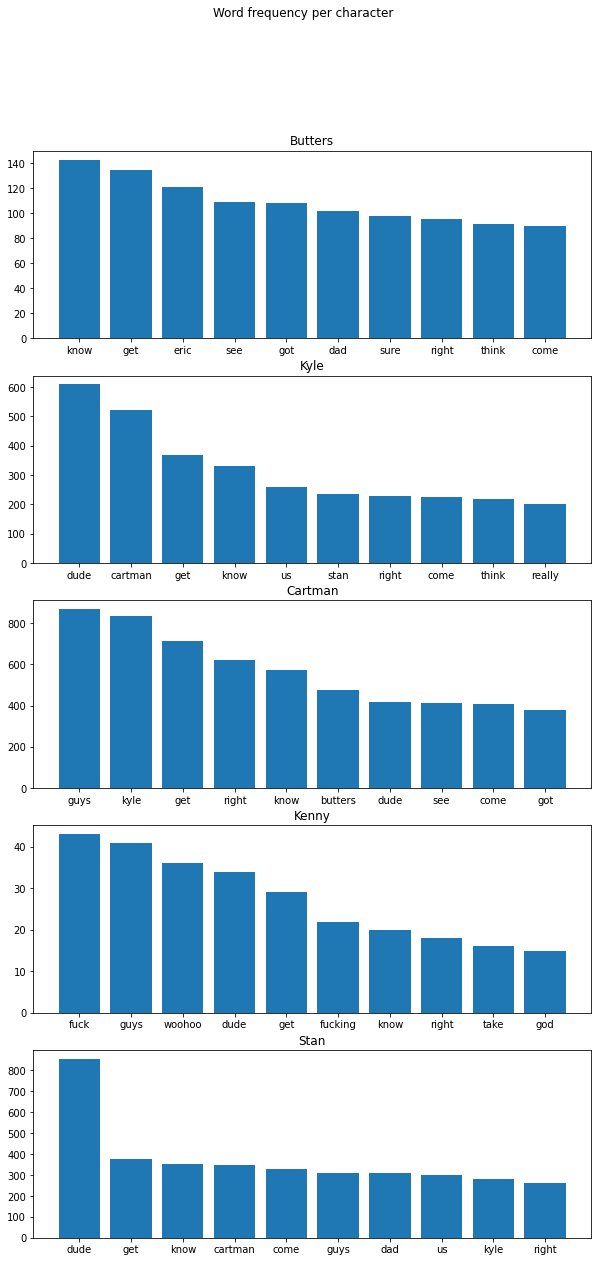

In [9]:
word_freq(['Butters', 'Kyle', 'Cartman', 'Kenny', 'Stan'], south_park)

In [10]:
seq_length(['Butters', 'Kyle', 'Cartman', 'Kenny', 'Stan'], south_park)

['Butters has an average utterance length of 11.620292083013068',
 'Kyle has an average utterance length of 9.190449359064656',
 'Cartman has an average utterance length of 13.69500716185799',
 'Kenny has an average utterance length of 5.009080590238366',
 'Stan has an average utterance length of 9.195703125']

In [11]:
swearing(['Butters', 'Kyle', 'Cartman', 'Kenny', 'Stan'], south_park)

['Butters speaks 13990 words, of which 637 are swear words. This is 5%',
 'Kyle speaks 30234 words, of which 2019 are swear words. This is 7%',
 'Cartman speaks 63752 words, of which 4432 are swear words. This is 7%',
 'Kenny speaks 1990 words, of which 227 are swear words. This is 11%',
 'Stan speaks 32874 words, of which 1970 are swear words. This is 6%']

#### Friends Dataset

The Friends corpus also spans 10 seasons and includes utterance id, utterance, to who the utterance is spoken to, the tokens (tokenized utterance/line), the season and episode information, a big5 personality label, etc. Similar to the South Park dataset, only the relevant columns were kept and similar processing steps such as labelling were executed outside of this notebook. The only difference is that tokenization and cleaning wasn't necessary as it was already included.

In [12]:
def load_friends(in_file):
    with open(in_file) as f:
        content = f.readlines()
        
    # Load json lines and keep columns of interest
    df = pd.DataFrame([json.loads(line) for line in content])
    df = df[['speaker', 'text']]
    df = df[df['speaker'] != 'TRANSCRIPT_NOTE']
    
    significant_characters = df['speaker'].value_counts()[:30]
    genders, ages = label('friends', significant_characters.index)
    
    df['source'] = 'Friends'
    df['gender'] = df['speaker'].apply(lambda x: genders[x])
    df['age'] = df['speaker'].apply(lambda x: ages[x])

    df['length'] = df['text'].apply(lambda x: x.count(' ') + 1)
    
    return df

In [13]:
friends = load_friends('data/friends.jsonl')

100%|██████████| 30/30 [00:04<00:00,  6.59it/s]


In [14]:
seq_length(['Monica Geller', 'Rachel Green', 'Phoebe Buffay', 'Joey Tribbiani', 'Chandler Bing', 'Ross Geller'], friends)

['Monica Geller has an average utterance length of 9.778771475641328',
 'Rachel Green has an average utterance length of 10.466938163112207',
 'Phoebe Buffay has an average utterance length of 10.82239023743202',
 'Joey Tribbiani has an average utterance length of 10.534023128423616',
 'Chandler Bing has an average utterance length of 10.135971055088703',
 'Ross Geller has an average utterance length of 10.43193974456937']

In [15]:
swearing(['Monica Geller', 'Rachel Green', 'Phoebe Buffay', 'Joey Tribbiani', 'Chandler Bing', 'Ross Geller'], friends)

['Monica Geller speaks 36412 words, of which 967 are swear words. This is 3%',
 'Rachel Green speaks 41765 words, of which 1161 are swear words. This is 3%',
 'Phoebe Buffay speaks 35690 words, of which 1008 are swear words. This is 3%',
 'Joey Tribbiani speaks 38091 words, of which 894 are swear words. This is 2%',
 'Chandler Bing speaks 37933 words, of which 949 are swear words. This is 3%',
 'Ross Geller speaks 42095 words, of which 857 are swear words. This is 2%']

#### Movies Dataset
This dataset was composed of multiple movies and hand annotated 

In [16]:
def load_movies(lines_file, meta_file):
    # Load dataframes
    kwargs = { 'delimiter': '\ \+\+\+\$\+\+\+\ ', 'encoding' : 'latin-1', 'header' : None }
    line_df = pd.read_csv(lines_file, engine='python', **kwargs)
    meta_df = pd.read_csv(meta_file, engine='python', **kwargs)

    # Set column names
    line_df.columns = ['line_id','char_id','movie_id','char_name','text']
    meta_df.columns = ['char_id','char_name','movie_id', 'movie_name','gender','credits_pos']

    # Fromalize meta dataframe
    meta_df['gender'] = meta_df['gender'].str.strip()
    meta_df = meta_df[meta_df['gender'] != '?']
    meta_df['gender'] = meta_df['gender'].apply(lambda x: 'Male' if x in ['m', 'M'] else 'Female') 

    # Merge meta and lines df's on movie_id and char_name
    df = pd.merge(line_df, meta_df, how='inner', on=['movie_id', 'char_name'],
                  left_index=False, right_index=False, sort=True, copy=False,
                  indicator=False).drop('char_id_y', axis=1)
    df = df.rename(columns={ 'char_id_x': 'char_id' })

    # Cleanup final df
    df['age'] = df['char_id'].apply(lambda x: data_utils.MOVIE_CHAR_TO_AGE.get(x))
    df = df[['movie_name', 'char_name', 'text', 'age', 'gender']]
    df = df.rename(columns={ 'movie_name': 'source', 'char_name': 'speaker' })

    df['length'] = df['text'].apply(lambda x: x.count(' ') + 1)

    return df

In [17]:
movies = load_movies('data/movie_lines.txt', 'data/movie_meta.txt')

In [18]:
full_df = pd.concat([movies, friends, south_park])
full_df = full_df[full_df['length'] < 100]

### Approaches
In this section, we will elaborate on the models we have used, after which we initialize and train our classification models on the datasets. 

#### Models used
BERT (Bidirectional Encoder Representations from Transformers) is a method of pre-training language representations. This means that we train a general-purpose model which is able to understand the language on a text corpus (In our case, the datasets mentioned earlier). The pre-trained model is thereafter used for NLP tasks, such as text classification. We have decided to use BERT since it is a state-of-the-art encoder which has shown to outperform previous methods. BERT’s key technical innovation is the application of a bi-directional Transformer (an attention model) on language modelling tasks. This model has a better sense of context within a  language and has shown outstanding results for NLP-tasks[9]. Moreover, its code is open-source and user-friendly, making it possible to actually use and implement it.

We used the smaller version of Google’s BERT model, called ‘DistilBERT’ to process the input dialogue lines and extract information from it. A smaller version was used since we had limited computational power. The information is encoded in the form of a vector/matrix that can be seen as the embedding of the input. This vector is used by the scikit Logistic Regression model to actually do the classification by predicting the labels. We used a pre-trained DistilBERT model that was trained on the English language.


In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load BERT
bert_model = ppb.DistilBertModel.from_pretrained('distilbert-base-uncased')
bert_tokenizer = ppb.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = bert_model.to(device)

The get_bert_features() function does the following: encoding the dialogue lines in a desired-format for BERT, padding and masking the input and finally returning the features. The BERT tokenizer, besides encoding the sentences, also adds special tokens, which are needed for classification, at the beginning and end of a sequence. Next, the tokenizer replaces the tokens with corresponding ids from the embedding table. This results in a list of lists or vectors of uneven lengths. In order to be able to give the input to DistilBERT in one go, we need to make it a suitable input matrix. To do so, the vectors need to be padded to equal sizes. The shorter sentences are padded with an id of 0. Nevertheless, we don’t want DistilBERT to read those zeroes, hence we mask them to let BERT know that they should be ignored. Finally, the input matrix can be given to DistilBERT. The processed results are given to ‘last_hidden_states’. The features we want is only a slice of the full output, corresponding to the complete sentence embeddings. 

The get_bert_features() function was used on both the age and gender training and test sets to obtain age and gender features as input for the LR models. It should be noted that the padding step of the get_bert_features() function results in a sparse matrix, which can take a lot of unnecessary computing power. For example, if in the dataset, there’s one sentence that’s 200 tokens long, whilst most lines only consist of 50 tokens, then the resulting matrix will have a lot of insignificant zeros. To limit the amount of zeros in the input matrix, we constrain the length of sentences given to the get_bert_features() function.
The features and corresponding labels were first again split into training and test features with a 3:1 ratio. Here, the test features are used to test the accuracy of the LR model. We used separate LR models for age and gender, because they are 2 separate predictions. The models were trained using the train features and tested with the test features.

In [20]:
def get_bert_features(batch):
    encoded = batch['text'].apply(lambda x: bert_tokenizer.encode(x, add_special_tokens=True))
    
    # Apply zero-padding
    max_len = max(len(x) for x in encoded.values)
    padded = np.array([x + [0] * (max_len - len(x)) for x in encoded.values])

    # Calculate attention mask
    mask = np.where(padded != 0, 1, 0)
    
    # Create input tensors for BERT
    X = torch.tensor(padded).to(device)
    mask = torch.tensor(mask).to(device)
    
    # Forward input through model
    with torch.no_grad():
        y = bert_model(X, attention_mask=mask)
    result = y[0][:, 0, :].cpu().numpy()
    
    # Clear CUDA memory
    if device == 'cuda':
        del X, mask, y
        torch.cuda.empty_cache()
    return result

In [21]:
batch_size = 256

In [22]:
full_df['features'] = None
for i in tqdm(range(0, len(full_df), batch_size)):
    features = get_bert_features(full_df[i:i + batch_size])
    features_df = pd.DataFrame(data={ 'features': list(features) })
    full_df.iloc[i:i + batch_size, -1] = pd.DataFrame(data={ 'features': list(features) })

100%|██████████| 1459/1459 [12:51<00:00,  1.89it/s]


In [23]:
gen_df = full_df[(full_df['gender'].notnull()) & (full_df['gender'] != '')]
age_df = full_df[(full_df['age'].notnull()) & (full_df['age'] != '')]

Male      234229
Female    101137
Name: gender, dtype: int64

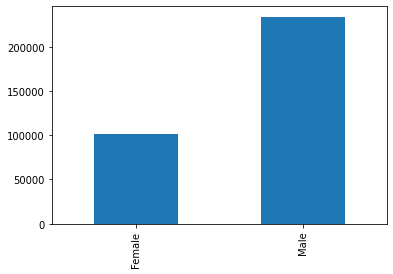

In [24]:
gen_df['gender'].value_counts().sort_values().plot(kind='bar')
gen_df['gender'].value_counts()

young adult (20-35)    53226
teen (10-19)           29685
adult (36-50)           6036
kid (0-9)               1197
elderly (50+)            408
Name: age, dtype: int64

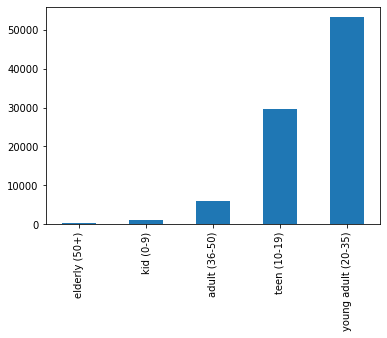

In [25]:
age_df['age'].value_counts().sort_values().plot(kind='bar')
age_df['age'].value_counts()

Since the distributions were rather skewed in all the shows, we had to mix and match data from the 3 corpora in order to obtain somewhat fair training and test datasets. Doing so helps prevent the classifier from learning biased predictions, because of certain labels occurring much more frequently in the training data. This opposed our original idea of using one or two datasets as training data and the others as test data to see if the trained model also worked on other corpora.



**Distribution rectification to be added**

In [26]:
# Initialize models
gen_model = LogisticRegression(n_jobs=4)
age_model = LogisticRegression(n_jobs=4)

We selected a range of characters from the 3 datasets with specific gender and age labels. For the training dataset we sampled the dialogue equally across those with different gender and age labels. The test set consists of multiple dataframes with the residual dialogue of one specific character. This test set will be used to test the accuracy of the model, predicting labels for a specific character. We created two separate training and test sets for age and gender.

Using the training datasets, the logistic regression models are trained.

In [27]:
split = train_test_split(gen_df['features'], gen_df['gender'], test_size=0.2)
X_gen_train, X_gen_test, y_gen_train, y_gen_test = split

X_gen_train = np.array(X_gen_train.values.tolist())
y_gen_train = np.array(y_gen_train.values.tolist())

gen_model.fit(X_gen_train, y_gen_train)

LogisticRegression(n_jobs=4)

In [28]:
split = train_test_split(age_df['features'], age_df['age'], test_size=0.2)
X_age_train, X_age_test, y_age_train, y_age_test = split

X_age_train = np.array(X_age_train.values.tolist())
y_age_train = np.array(y_age_train.values.tolist())

age_model.fit(X_age_train, y_age_train)

LogisticRegression(n_jobs=4)

For personality predictions a biderectional LSTM with attention mechanisms is used. Code from the <a href='https://github.com/hjian42/automatic-personality-prediction'>Modeling Personality with Attentive Networks and Contextual Embeddings</a> is used and sligthly modified to train the model. The `train_persona` function trains the LSTM model using 10-fold cross-validation, from which the best performing model is stored, such that the model can be used later on. To reduce the complexity of the task, for each personality trait a seperate model is trained. Each model then learns to score a piece of conversation for a single personality trait. 

In [29]:
config.ModelName = 'Attention'
config.Params.n_epoch = 50

train_persona(config)

The size of data is 711
BEFORE Pruning:
Min=2, Mean=56, Max=443
Total majority is 56.962025316455694 for cAGR.
Real Vocab Size: 3542
Truncated Vocab Size: 10000
AFTER Pruning:
Min=1, Mean=29, Max=218
Total majority is 56.962025316455694 for cAGR.

Epoch 00001: val_accuracy improved from -inf to 0.56944, saving model to models/cAGR_cur.h5

Epoch 00002: val_accuracy did not improve from 0.56944

Epoch 00003: val_accuracy did not improve from 0.56944

Epoch 00004: val_accuracy did not improve from 0.56944

Epoch 00005: val_accuracy did not improve from 0.56944

Epoch 00006: val_accuracy did not improve from 0.56944

Epoch 00007: val_accuracy did not improve from 0.56944

Epoch 00008: val_accuracy did not improve from 0.56944

Epoch 00009: val_accuracy improved from 0.56944 to 0.62500, saving model to models/cAGR_cur.h5

Epoch 00010: val_accuracy did not improve from 0.62500

Epoch 00011: val_accuracy did not improve from 0.62500

Epoch 00012: val_accuracy did not improve from 0.62500

Epo


Epoch 00028: val_accuracy did not improve from 0.59155

Epoch 00029: val_accuracy did not improve from 0.59155

Epoch 00030: val_accuracy did not improve from 0.59155

Epoch 00031: val_accuracy did not improve from 0.59155

Epoch 00032: val_accuracy did not improve from 0.59155

Epoch 00033: val_accuracy did not improve from 0.59155

Epoch 00034: val_accuracy did not improve from 0.59155

Epoch 00035: val_accuracy did not improve from 0.59155

Epoch 00036: val_accuracy did not improve from 0.59155

Epoch 00037: val_accuracy did not improve from 0.59155

Epoch 00038: val_accuracy did not improve from 0.59155

Epoch 00039: val_accuracy did not improve from 0.59155

Epoch 00040: val_accuracy did not improve from 0.59155

Epoch 00041: val_accuracy did not improve from 0.59155

Epoch 00042: val_accuracy did not improve from 0.59155

Epoch 00043: val_accuracy did not improve from 0.59155

Epoch 00044: val_accuracy did not improve from 0.59155

Epoch 00045: val_accuracy did not improve from 


Epoch 00011: val_accuracy improved from 0.60563 to 0.64789, saving model to models/cAGR_cur.h5

Epoch 00012: val_accuracy did not improve from 0.64789

Epoch 00013: val_accuracy did not improve from 0.64789

Epoch 00014: val_accuracy did not improve from 0.64789

Epoch 00015: val_accuracy did not improve from 0.64789

Epoch 00016: val_accuracy did not improve from 0.64789

Epoch 00017: val_accuracy did not improve from 0.64789

Epoch 00018: val_accuracy did not improve from 0.64789

Epoch 00019: val_accuracy did not improve from 0.64789

Epoch 00020: val_accuracy did not improve from 0.64789

Epoch 00021: val_accuracy did not improve from 0.64789

Epoch 00022: val_accuracy did not improve from 0.64789

Epoch 00023: val_accuracy did not improve from 0.64789

Epoch 00024: val_accuracy did not improve from 0.64789

Epoch 00025: val_accuracy did not improve from 0.64789

Epoch 00026: val_accuracy did not improve from 0.64789

Epoch 00027: val_accuracy did not improve from 0.64789

Epoch 0


Epoch 00048: val_accuracy did not improve from 0.70423

Epoch 00049: val_accuracy did not improve from 0.70423

Epoch 00050: val_accuracy did not improve from 0.70423
working on ==cAGR==
----cAGR: 8----
----highest evaluation accuracy is 70.422536
----dominant distribution in data is 56.962025
New best evaluation, saving model to models/cAGR_best.h5

Epoch 00001: val_accuracy improved from -inf to 0.57746, saving model to models/cAGR_cur.h5

Epoch 00002: val_accuracy did not improve from 0.57746

Epoch 00003: val_accuracy did not improve from 0.57746

Epoch 00004: val_accuracy did not improve from 0.57746

Epoch 00005: val_accuracy did not improve from 0.57746

Epoch 00006: val_accuracy did not improve from 0.57746

Epoch 00007: val_accuracy did not improve from 0.57746

Epoch 00008: val_accuracy improved from 0.57746 to 0.59155, saving model to models/cAGR_cur.h5

Epoch 00009: val_accuracy did not improve from 0.59155

Epoch 00010: val_accuracy did not improve from 0.59155

Epoch 000


Epoch 00026: val_accuracy did not improve from 0.58333

Epoch 00027: val_accuracy did not improve from 0.58333

Epoch 00028: val_accuracy did not improve from 0.58333

Epoch 00029: val_accuracy did not improve from 0.58333

Epoch 00030: val_accuracy did not improve from 0.58333

Epoch 00031: val_accuracy did not improve from 0.58333

Epoch 00032: val_accuracy did not improve from 0.58333

Epoch 00033: val_accuracy did not improve from 0.58333

Epoch 00034: val_accuracy did not improve from 0.58333

Epoch 00035: val_accuracy did not improve from 0.58333

Epoch 00036: val_accuracy did not improve from 0.58333

Epoch 00037: val_accuracy did not improve from 0.58333

Epoch 00038: val_accuracy did not improve from 0.58333

Epoch 00039: val_accuracy did not improve from 0.58333

Epoch 00040: val_accuracy did not improve from 0.58333

Epoch 00041: val_accuracy did not improve from 0.58333

Epoch 00042: val_accuracy did not improve from 0.58333

Epoch 00043: val_accuracy did not improve from 


Epoch 00010: val_accuracy did not improve from 0.53521

Epoch 00011: val_accuracy did not improve from 0.53521

Epoch 00012: val_accuracy did not improve from 0.53521

Epoch 00013: val_accuracy did not improve from 0.53521

Epoch 00014: val_accuracy did not improve from 0.53521

Epoch 00015: val_accuracy did not improve from 0.53521

Epoch 00016: val_accuracy did not improve from 0.53521

Epoch 00017: val_accuracy did not improve from 0.53521

Epoch 00018: val_accuracy did not improve from 0.53521

Epoch 00019: val_accuracy did not improve from 0.53521

Epoch 00020: val_accuracy did not improve from 0.53521

Epoch 00021: val_accuracy did not improve from 0.53521

Epoch 00022: val_accuracy did not improve from 0.53521

Epoch 00023: val_accuracy did not improve from 0.53521

Epoch 00024: val_accuracy did not improve from 0.53521

Epoch 00025: val_accuracy did not improve from 0.53521

Epoch 00026: val_accuracy did not improve from 0.53521

Epoch 00027: val_accuracy did not improve from 


Epoch 00049: val_accuracy did not improve from 0.59155

Epoch 00050: val_accuracy did not improve from 0.59155
working on ==cCON==
----cCON: 6----
----highest evaluation accuracy is 59.154928
----dominant distribution in data is 53.586498

Epoch 00001: val_accuracy improved from -inf to 0.53521, saving model to models/cCON_cur.h5

Epoch 00002: val_accuracy did not improve from 0.53521

Epoch 00003: val_accuracy did not improve from 0.53521

Epoch 00004: val_accuracy did not improve from 0.53521

Epoch 00005: val_accuracy did not improve from 0.53521

Epoch 00006: val_accuracy did not improve from 0.53521

Epoch 00007: val_accuracy did not improve from 0.53521

Epoch 00008: val_accuracy did not improve from 0.53521

Epoch 00009: val_accuracy did not improve from 0.53521

Epoch 00010: val_accuracy did not improve from 0.53521

Epoch 00011: val_accuracy did not improve from 0.53521

Epoch 00012: val_accuracy did not improve from 0.53521

Epoch 00013: val_accuracy did not improve from 0.5


Epoch 00036: val_accuracy improved from 0.53521 to 0.54930, saving model to models/cCON_cur.h5

Epoch 00037: val_accuracy did not improve from 0.54930

Epoch 00038: val_accuracy did not improve from 0.54930

Epoch 00039: val_accuracy did not improve from 0.54930

Epoch 00040: val_accuracy did not improve from 0.54930

Epoch 00041: val_accuracy did not improve from 0.54930

Epoch 00042: val_accuracy did not improve from 0.54930

Epoch 00043: val_accuracy did not improve from 0.54930

Epoch 00044: val_accuracy did not improve from 0.54930

Epoch 00045: val_accuracy did not improve from 0.54930

Epoch 00046: val_accuracy did not improve from 0.54930

Epoch 00047: val_accuracy did not improve from 0.54930

Epoch 00048: val_accuracy did not improve from 0.54930

Epoch 00049: val_accuracy did not improve from 0.54930

Epoch 00050: val_accuracy did not improve from 0.54930
working on ==cCON==
----cCON: 9----
----highest evaluation accuracy is 54.929578
----dominant distribution in data is 53


Epoch 00013: val_accuracy did not improve from 0.56338

Epoch 00014: val_accuracy did not improve from 0.56338

Epoch 00015: val_accuracy did not improve from 0.56338

Epoch 00016: val_accuracy did not improve from 0.56338

Epoch 00017: val_accuracy did not improve from 0.56338

Epoch 00018: val_accuracy did not improve from 0.56338

Epoch 00019: val_accuracy did not improve from 0.56338

Epoch 00020: val_accuracy did not improve from 0.56338

Epoch 00021: val_accuracy did not improve from 0.56338

Epoch 00022: val_accuracy did not improve from 0.56338

Epoch 00023: val_accuracy did not improve from 0.56338

Epoch 00024: val_accuracy did not improve from 0.56338

Epoch 00025: val_accuracy did not improve from 0.56338

Epoch 00026: val_accuracy improved from 0.56338 to 0.57746, saving model to models/cEXT_cur.h5

Epoch 00027: val_accuracy did not improve from 0.57746

Epoch 00028: val_accuracy did not improve from 0.57746

Epoch 00029: val_accuracy did not improve from 0.57746

Epoch 0


Epoch 00050: val_accuracy did not improve from 0.57746
working on ==cEXT==
----cEXT: 4----
----highest evaluation accuracy is 57.746476
----dominant distribution in data is 56.118143

Epoch 00001: val_accuracy improved from -inf to 0.56338, saving model to models/cEXT_cur.h5

Epoch 00002: val_accuracy did not improve from 0.56338

Epoch 00003: val_accuracy did not improve from 0.56338

Epoch 00004: val_accuracy did not improve from 0.56338

Epoch 00005: val_accuracy did not improve from 0.56338

Epoch 00006: val_accuracy did not improve from 0.56338

Epoch 00007: val_accuracy did not improve from 0.56338

Epoch 00008: val_accuracy did not improve from 0.56338

Epoch 00009: val_accuracy did not improve from 0.56338

Epoch 00010: val_accuracy improved from 0.56338 to 0.57746, saving model to models/cEXT_cur.h5

Epoch 00011: val_accuracy did not improve from 0.57746

Epoch 00012: val_accuracy did not improve from 0.57746

Epoch 00013: val_accuracy did not improve from 0.57746

Epoch 0001


Epoch 00033: val_accuracy did not improve from 0.56338

Epoch 00034: val_accuracy did not improve from 0.56338

Epoch 00035: val_accuracy did not improve from 0.56338

Epoch 00036: val_accuracy did not improve from 0.56338

Epoch 00037: val_accuracy did not improve from 0.56338

Epoch 00038: val_accuracy did not improve from 0.56338

Epoch 00039: val_accuracy did not improve from 0.56338

Epoch 00040: val_accuracy did not improve from 0.56338

Epoch 00041: val_accuracy did not improve from 0.56338

Epoch 00042: val_accuracy did not improve from 0.56338

Epoch 00043: val_accuracy did not improve from 0.56338

Epoch 00044: val_accuracy did not improve from 0.56338

Epoch 00045: val_accuracy did not improve from 0.56338

Epoch 00046: val_accuracy did not improve from 0.56338

Epoch 00047: val_accuracy did not improve from 0.56338

Epoch 00048: val_accuracy did not improve from 0.56338

Epoch 00049: val_accuracy did not improve from 0.56338

Epoch 00050: val_accuracy did not improve from 


Epoch 00021: val_accuracy did not improve from 0.56338

Epoch 00022: val_accuracy did not improve from 0.56338

Epoch 00023: val_accuracy did not improve from 0.56338

Epoch 00024: val_accuracy did not improve from 0.56338

Epoch 00025: val_accuracy did not improve from 0.56338

Epoch 00026: val_accuracy did not improve from 0.56338

Epoch 00027: val_accuracy did not improve from 0.56338

Epoch 00028: val_accuracy did not improve from 0.56338

Epoch 00029: val_accuracy did not improve from 0.56338

Epoch 00030: val_accuracy did not improve from 0.56338

Epoch 00031: val_accuracy did not improve from 0.56338

Epoch 00032: val_accuracy did not improve from 0.56338

Epoch 00033: val_accuracy did not improve from 0.56338

Epoch 00034: val_accuracy did not improve from 0.56338

Epoch 00035: val_accuracy improved from 0.56338 to 0.57746, saving model to models/cEXT_cur.h5

Epoch 00036: val_accuracy did not improve from 0.57746

Epoch 00037: val_accuracy did not improve from 0.57746

Epoch 0


Epoch 00001: val_accuracy improved from -inf to 0.64789, saving model to models/cOPN_cur.h5

Epoch 00002: val_accuracy did not improve from 0.64789

Epoch 00003: val_accuracy did not improve from 0.64789

Epoch 00004: val_accuracy did not improve from 0.64789

Epoch 00005: val_accuracy did not improve from 0.64789

Epoch 00006: val_accuracy did not improve from 0.64789

Epoch 00007: val_accuracy did not improve from 0.64789

Epoch 00008: val_accuracy did not improve from 0.64789

Epoch 00009: val_accuracy did not improve from 0.64789

Epoch 00010: val_accuracy did not improve from 0.64789

Epoch 00011: val_accuracy did not improve from 0.64789

Epoch 00012: val_accuracy did not improve from 0.64789

Epoch 00013: val_accuracy did not improve from 0.64789

Epoch 00014: val_accuracy did not improve from 0.64789

Epoch 00015: val_accuracy did not improve from 0.64789

Epoch 00016: val_accuracy did not improve from 0.64789

Epoch 00017: val_accuracy did not improve from 0.64789

Epoch 0001


Epoch 00041: val_accuracy did not improve from 0.66197

Epoch 00042: val_accuracy did not improve from 0.66197

Epoch 00043: val_accuracy did not improve from 0.66197

Epoch 00044: val_accuracy did not improve from 0.66197

Epoch 00045: val_accuracy did not improve from 0.66197

Epoch 00046: val_accuracy did not improve from 0.66197

Epoch 00047: val_accuracy did not improve from 0.66197

Epoch 00048: val_accuracy did not improve from 0.66197

Epoch 00049: val_accuracy did not improve from 0.66197

Epoch 00050: val_accuracy did not improve from 0.66197
working on ==cOPN==
----cOPN: 5----
----highest evaluation accuracy is 66.197181
----dominant distribution in data is 64.978903

Epoch 00001: val_accuracy improved from -inf to 0.64789, saving model to models/cOPN_cur.h5

Epoch 00002: val_accuracy did not improve from 0.64789

Epoch 00003: val_accuracy did not improve from 0.64789

Epoch 00004: val_accuracy did not improve from 0.64789

Epoch 00005: val_accuracy did not improve from 0.6


Epoch 00026: val_accuracy did not improve from 0.69014

Epoch 00027: val_accuracy did not improve from 0.69014

Epoch 00028: val_accuracy did not improve from 0.69014

Epoch 00029: val_accuracy did not improve from 0.69014

Epoch 00030: val_accuracy did not improve from 0.69014

Epoch 00031: val_accuracy did not improve from 0.69014

Epoch 00032: val_accuracy did not improve from 0.69014

Epoch 00033: val_accuracy did not improve from 0.69014

Epoch 00034: val_accuracy did not improve from 0.69014

Epoch 00035: val_accuracy did not improve from 0.69014

Epoch 00036: val_accuracy did not improve from 0.69014

Epoch 00037: val_accuracy did not improve from 0.69014

Epoch 00038: val_accuracy did not improve from 0.69014

Epoch 00039: val_accuracy did not improve from 0.69014

Epoch 00040: val_accuracy did not improve from 0.69014

Epoch 00041: val_accuracy did not improve from 0.69014

Epoch 00042: val_accuracy did not improve from 0.69014

Epoch 00043: val_accuracy did not improve from 


Epoch 00008: val_accuracy did not improve from 0.52778

Epoch 00009: val_accuracy improved from 0.52778 to 0.62500, saving model to models/cNEU_cur.h5

Epoch 00010: val_accuracy improved from 0.62500 to 0.63889, saving model to models/cNEU_cur.h5

Epoch 00011: val_accuracy did not improve from 0.63889

Epoch 00012: val_accuracy did not improve from 0.63889

Epoch 00013: val_accuracy did not improve from 0.63889

Epoch 00014: val_accuracy did not improve from 0.63889

Epoch 00015: val_accuracy did not improve from 0.63889

Epoch 00016: val_accuracy did not improve from 0.63889

Epoch 00017: val_accuracy did not improve from 0.63889

Epoch 00018: val_accuracy did not improve from 0.63889

Epoch 00019: val_accuracy did not improve from 0.63889

Epoch 00020: val_accuracy did not improve from 0.63889

Epoch 00021: val_accuracy did not improve from 0.63889

Epoch 00022: val_accuracy did not improve from 0.63889

Epoch 00023: val_accuracy did not improve from 0.63889

Epoch 00024: val_accura


Epoch 00045: val_accuracy did not improve from 0.54930

Epoch 00046: val_accuracy did not improve from 0.54930

Epoch 00047: val_accuracy did not improve from 0.54930

Epoch 00048: val_accuracy did not improve from 0.54930

Epoch 00049: val_accuracy did not improve from 0.54930

Epoch 00050: val_accuracy did not improve from 0.54930
working on ==cNEU==
----cNEU: 3----
----highest evaluation accuracy is 54.929578
----dominant distribution in data is 53.305204

Epoch 00001: val_accuracy improved from -inf to 0.53521, saving model to models/cNEU_cur.h5

Epoch 00002: val_accuracy did not improve from 0.53521

Epoch 00003: val_accuracy did not improve from 0.53521

Epoch 00004: val_accuracy did not improve from 0.53521

Epoch 00005: val_accuracy did not improve from 0.53521

Epoch 00006: val_accuracy did not improve from 0.53521

Epoch 00007: val_accuracy did not improve from 0.53521

Epoch 00008: val_accuracy did not improve from 0.53521

Epoch 00009: val_accuracy did not improve from 0.5


Epoch 00029: val_accuracy did not improve from 0.53521

Epoch 00030: val_accuracy did not improve from 0.53521

Epoch 00031: val_accuracy did not improve from 0.53521

Epoch 00032: val_accuracy did not improve from 0.53521

Epoch 00033: val_accuracy did not improve from 0.53521

Epoch 00034: val_accuracy did not improve from 0.53521

Epoch 00035: val_accuracy did not improve from 0.53521

Epoch 00036: val_accuracy did not improve from 0.53521

Epoch 00037: val_accuracy did not improve from 0.53521

Epoch 00038: val_accuracy did not improve from 0.53521

Epoch 00039: val_accuracy did not improve from 0.53521

Epoch 00040: val_accuracy did not improve from 0.53521

Epoch 00041: val_accuracy did not improve from 0.53521

Epoch 00042: val_accuracy did not improve from 0.53521

Epoch 00043: val_accuracy did not improve from 0.53521

Epoch 00044: val_accuracy did not improve from 0.53521

Epoch 00045: val_accuracy did not improve from 0.53521

Epoch 00046: val_accuracy did not improve from 


Epoch 00014: val_accuracy improved from 0.56338 to 0.59155, saving model to models/cNEU_cur.h5

Epoch 00015: val_accuracy did not improve from 0.59155

Epoch 00016: val_accuracy did not improve from 0.59155

Epoch 00017: val_accuracy did not improve from 0.59155

Epoch 00018: val_accuracy did not improve from 0.59155

Epoch 00019: val_accuracy improved from 0.59155 to 0.60563, saving model to models/cNEU_cur.h5

Epoch 00020: val_accuracy did not improve from 0.60563

Epoch 00021: val_accuracy did not improve from 0.60563

Epoch 00022: val_accuracy did not improve from 0.60563

Epoch 00023: val_accuracy did not improve from 0.60563

Epoch 00024: val_accuracy did not improve from 0.60563

Epoch 00025: val_accuracy did not improve from 0.60563

Epoch 00026: val_accuracy improved from 0.60563 to 0.61972, saving model to models/cNEU_cur.h5

Epoch 00027: val_accuracy improved from 0.61972 to 0.63380, saving model to models/cNEU_cur.h5

Epoch 00028: val_accuracy did not improve from 0.63380


## Evaluation
To evaluate the trained gender and age prediction model, we run the test dataset with its corresponding labels through the scikit Logistic Regression *score* function. The *score* function computes the mean accuracy of the given input, by running every data row of the test set through the scikit Logistic Regression *predict* function and comparing the predicted label with the actual label. Hence, the mean accuracy represents the percentage of correctly predicted labels.

In [30]:
X_gen_test = np.array(X_gen_test.values.tolist())
y_gen_test = np.array(y_gen_test.values.tolist())

gen_model.score(X_gen_test, y_gen_test)

0.7052210990845932

In [31]:
X_age_test = np.array(X_age_test.values.tolist())
y_age_test = np.array(y_age_test.values.tolist())

age_model.score(X_age_test, y_age_test)

0.726022859035945


Thus now the models are able to predict or classify a gender and age label, given a dialogue line with an about 70% accuracy. However, we want to predict the gender and age of a character given all his/her dialogue lines. To do so, we simply let the model predict labels for each line of a specific character and take the most frequent label as final prediction. The dialogue lines also go through the get_bert_features() function in order to become a suitable format for the model. 

### Results

In [33]:
gen_sample_row = gen_df.sample().values[0]
y_hat = gen_model.predict([gen_sample_row[-1].tolist()])[0]
print(f'predicted {y_hat} for {gen_sample_row[1]}, actual: {gen_sample_row[4]}\n dialogue: {gen_sample_row[2]}')

predicted Male for Ross Geller, actual: Male
 dialogue: Mmm hmmm.


In [34]:
age_sample_row = age_df.sample().values[0]
y_hat = age_model.predict([age_sample_row[-1].tolist()])[0]
print(f'predicted {y_hat} for {age_sample_row[1]}, actual: {age_sample_row[3]}\n dialogue: {age_sample_row[2]}')

predicted teen (10-19) for JULIE, actual: young adult (20-35)
 dialogue: What's the maximum safe dose?


**TODO: Personalities results**

## Findings
The reasonable results suggest that it is possible to predict the selected profile features given the dialogue of a person/character. It can even be said that it is possible to predict is quite well. However, the predictions aren't always perfect as we haven't acquired a +/- 100% accuracy. <br>
The results also indicate that the models are better at predicting gender than age.

### Discussion
1. Accuracy may be influenced by the mildly skewed data
2. Some of the data may have not been representative for the general age group. South Park, for example stars 5 young teenagers who use language that is usually not representative for ten year olds. In movies, fictional characters talk about things and experience things that are very unusual in other movies. For representative results for age groups, similar movies/tv-shows or general conversations need to be used. (to be elaborated)
3. The personality dataset contained just around 800 data points to train on. There was also only data available for the five Friends main characters, so an absolute judgement of how well it performs cannot be made. All Friends main characters have similar character traits, so for a more in-depth research, more  
4. A default LR model is only meant for prediction between 2 classes, instead of multi-classifications like age.


## Conclusions
In this final section we will briefly summarize the research we have conducted during this project and explain our findings. Then, we will elaborate on the lessons we have learned, and finally we will provide some suggestions of future work

### Summary
During this project we investigated if and to what extent dialogue could be used to predict profile features including gender, age and personality of a person, represented by movie and tv-show characters. The first part of the project consisted of cleaning and processing the datasets and analysing the contents and metadata. After having created a fairer training dataset, we could give the input to the models. For predicting gender and age we used a combination of the DistilBERT- and the Logistic Regression model. For predicting personality we have used a bi-directional LSTM. We evaluated the models based on the accuracy of their predictions. Furthermore, we elaborated the use of the models to predict the profile features of a character, based on all of their dialogue lines.

### Lessons learned
Possibly biased data and therefore predictions are a well-known problem in the field of artificial intelligence and machine learning. Doing this project we faced and realized the significance of this issue and the importance of trying to get a fair training dataset in order to get fair results. Although the task we achieved is relatively small and simple, it showed us that natural language processing can indeed be used in many different tasks and fields. We did realize however that the nature of the models restricts the transparency and explainability of the results. For example, we don’t know what features correspond more strongly to specific genders, age categories and personalities. Although the results are therefore not useful in knowing certain characteristics of speech, the predictions can still come in handy for when you want to have an estimation of someone’s profile features. Nevertheless, an analysis of profile features distinguishing features was outside the scope of this project and another project on its own.

This project also allowed us to take a look at state-of-the-art models and actually try them out, giving us more insight into the field of NLP. 

Lastly, naturally with a team project, we developed collaborating skills. This was especially essential during the current times of the pandemic, which forced us to keep each other updated and communicate planning and tasks.

### Future work
Even though the results of the project were interesting and promising, there is still a lot that could be improved. To e.g. increase the accuracy of the models, it might be useful to create a better and fairer training dataset. Although we did try to fairly sample all the datasets, within the scope of the project and the time we had, it wasn’t perfect. It might be promising to instead of using movie and tv-series as data, to use real-life transcripts of interviews, dialogues or chats, etc. This could be achieved by setting up an experiment and gather participants with a fair spread of desired profile features. Moreover, it could be insightful to try out different classification models and compare results and accuracy. When we want to predict a feature that can have multiple labels, it can be more suitable to use a classifier specialized in more classes, such as a multilayer perceptron or a multinomial bayes classifier. The research could also be extended to predicting other interesting profile features, such as education level or profession.

When a more accurate profile feature predictor can be built, it could be fruitful in usage for a chatbot. If a chatbot is able to guess characteristics of its conversation partner, then its conversational style and language usage could be adjusted accordingly, in order to make for smoother and more successful conversations. And if the chatbot is asked for e.g. movie recommendations, then it will perhaps be able to recommend more suitable movies.